In [24]:
import pandas as pd

In [25]:
df_test = pd.read_csv("final_label_train_2024.csv")

In [3]:
df_test_sample = df_test.sample(50)

In [26]:
from transformers import Wav2Vec2Processor, Wav2Vec2ProcessorWithLM, Wav2Vec2ForCTC

# Load processor
processor = Wav2Vec2Processor.from_pretrained("custom_model")

# Get the vocabulary dictionary
vocab_dict = processor.tokenizer.get_vocab()

# Remove <s> and </s> tokens if they exist
# vocab_dict = {k: v for k, v in vocab_dict.items() if k not in tokens_to_remove}

# Sort the vocabulary dictionary by the values (IDs)
sorted_vocab_dict = {k.lower(): v for k, v in sorted(vocab_dict.items(), key=lambda item: item[1])}

# Output the sorted vocabulary dictionary
print(sorted_vocab_dict)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'ẻ': 0, '6': 1, 'ụ': 2, 'í': 3, '3': 4, 'ỹ': 5, 'ý': 6, 'ẩ': 7, 'ở': 8, 'ề': 9, 'õ': 10, '7': 11, 'ê': 12, 'ứ': 13, 'ỏ': 14, 'v': 15, 'ỷ': 16, 'a': 17, 'l': 18, 'ự': 19, 'q': 20, 'ờ': 21, 'j': 22, 'ố': 23, 'à': 24, 'ỗ': 25, 'n': 26, 'é': 27, 'ủ': 28, 'у': 29, 'ô': 30, 'u': 31, 'y': 32, 'ằ': 33, '4': 34, 'w': 35, 'b': 36, 'ệ': 37, 'ễ': 38, 's': 39, 'ì': 40, 'ầ': 41, 'ỵ': 42, '8': 43, 'd': 44, 'ể': 45, '|': 46, 'r': 47, 'ũ': 48, 'c': 49, 'ạ': 50, '9': 51, 'ế': 52, 'ù': 53, 'ỡ': 54, '2': 55, 't': 56, 'i': 57, 'g': 58, '́': 59, 'ử': 60, '̀': 61, 'á': 62, '0': 63, 'ậ': 64, 'e': 65, 'ộ': 66, 'm': 67, 'ẳ': 68, 'ợ': 69, 'ĩ': 70, 'h': 71, 'â': 72, 'ú': 73, 'ọ': 74, 'ồ': 75, 'ặ': 76, 'f': 77, 'ữ': 78, 'ắ': 79, 'ỳ': 80, 'x': 81, 'ó': 82, 'ã': 83, 'ổ': 84, 'ị': 85, '̣': 86, 'z': 87, 'ả': 88, 'đ': 89, 'è': 90, 'ừ': 91, 'ò': 92, 'ẵ': 93, '1': 94, 'ơ': 95, 'k': 96, 'ẫ': 97, 'p': 98, 'ấ': 99, 'ẽ': 100, 'ỉ': 101, 'ớ': 102, 'ẹ': 103, 'ă': 104, 'o': 105, 'ư': 106, '5': 107, '<unk>': 108, '<pad>': 109, '

In [27]:
from pyctcdecode import build_ctcdecoder

decoder = build_ctcdecoder(
    labels=list(sorted_vocab_dict.keys()),
    kenlm_model_path="5gram_correct.arpa",
    alpha=1
)

Loading the LM will be faster if you build a binary file.
Reading /home/jovyan/ai-core/speech_to_text/nghia_semi_supervised/icra/5gram_correct.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?
Unigrams and labels don't seem to agree.


In [28]:
processor_with_lm = Wav2Vec2ProcessorWithLM(
    feature_extractor=processor.feature_extractor,
    tokenizer=processor.tokenizer,
    decoder=decoder
)

In [29]:
class Inferencer:
    def __init__(self, device, huggingface_folder, w2v_model_path, kenlm_model_path, alpha = 1.0):
        self.device = device
        self.processor = Wav2Vec2Processor.from_pretrained(huggingface_folder)
        vocab_dict = self.processor.tokenizer.get_vocab()
        sorted_vocab_dict = {k.lower(): v for k, v in sorted(vocab_dict.items(), key=lambda item: item[1])}
        self.decoder = build_ctcdecoder(
            labels=list(sorted_vocab_dict.keys()),
            kenlm_model_path=kenlm_model_path,
            alpha=alpha
        )
        self.processor_with_lm = Wav2Vec2ProcessorWithLM(
            feature_extractor=self.processor.feature_extractor,
            tokenizer=self.processor.tokenizer,
            decoder=self.decoder
        )
        self.model = Wav2Vec2ForCTC.from_pretrained(huggingface_folder).to(self.device)
        if w2v_model_path is not None:
            self.preload_model(w2v_model_path)


    def preload_model(self, model_path) -> None:
        """
        Preload model parameters (in "*.tar" format) at the start of experiment.
        Args:
            model_path: The file path of the *.tar file
        """
        assert os.path.exists(model_path), f"The file {model_path} is not exist. please check path."
        checkpoint = torch.load(model_path, map_location=self.device)
        self.model.load_state_dict(checkpoint, strict = True)
        print(f"Model preloaded successfully from {model_path}.")


    def transcribe(self, wav) -> str:
        input_values = self.processor(wav, sampling_rate=16000, return_tensors="pt").input_values
        logits = self.model(input_values.to(self.device)).logits
        pred_ids = torch.argmax(logits, dim=-1)
        pred_transcript = self.processor.batch_decode(pred_ids)[0]
        return pred_transcript

    def run(self, test_filepath):
        filename = test_filepath.split('/')[-1].split('.')[0]
        filetype = test_filepath.split('.')[1]
        if filetype == 'txt':
            f = open(test_filepath, 'r')
            lines = f.read().splitlines()
            f.close()

            f = open(test_filepath.replace(filename, 'transcript_'+filename), 'w+')
            for line in tqdm(lines):
                wav, _ = librosa.load(line, sr = 16000)
                transcript = self.transcribe(wav)
                f.write(line + ' ' + transcript + '\n')
            f.close()

        else:
            wav, _ = librosa.load(test_filepath, sr = 16000)
            return self.transcribe(wav)

In [30]:
from IPython.display import Audio
from jiwer import wer
import os
import torch

inference = Inferencer(device = "cuda", 
                        huggingface_folder="custom_model",
                        w2v_model_path="custom_model/pytorch_model.bin",
                        kenlm_model_path="5gram_correct.arpa")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading the LM will be faster if you build a binary file.
Reading /home/jovyan/ai-core/speech_to_text/nghia_semi_supervised/icra/5gram_correct.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?
Unigrams and labels don't seem to agree.
/home/jovyan/ai-core/miniconda3/envs/contentvec/lib/python3.7/site-packages/transformers/configuration_utils.py:381: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gra

Model preloaded successfully from custom_model/pytorch_model.bin.


In [31]:
import librosa
from tqdm import tqdm
predict_sentences = []
WERs = []
for _, row in tqdm(df_test.iterrows()):
    predict_sentence = inference.run(row["audio"])
    predict_sentences.append(predict_sentence)
    wer_score = wer(row["labeled_text"], predict_sentence)
    WERs.append(wer_score)

26937it [08:22, 53.61it/s]


In [32]:
df_test["predict_text"] = predict_sentences
df_test["WER"] = WERs
df_test["WER"].mean()

0.6144393445218221

In [43]:
df_test["WER"].mean

<bound method NDFrame._add_numeric_operations.<locals>.mean of 0        1.000000
1        0.250000
2        1.000000
3        0.571429
4        0.666667
           ...   
26932    0.166667
26933    0.090909
26934    0.125000
26935    0.217391
26936    1.000000
Name: WER, Length: 26937, dtype: float64>

In [39]:
import matplotlib.pyplot as plt

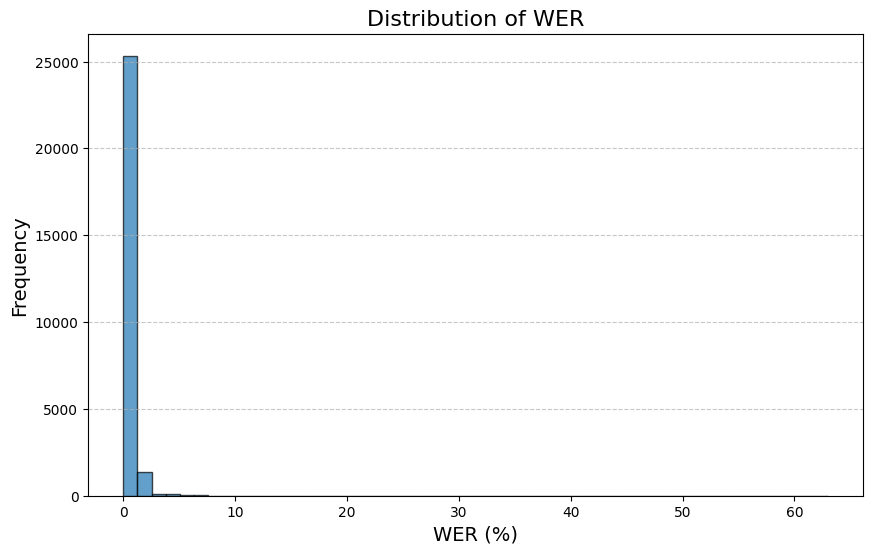

0.0     0.000000
0.1     0.096774
0.2     0.211538
0.3     0.294118
0.4     0.375000
0.5     0.500000
0.6     0.571429
0.7     0.750000
0.8     1.000000
0.9     1.000000
1.0    63.000000
Name: WER, dtype: float64

In [41]:
plt.figure(figsize=(10, 6))
plt.hist(df_test["WER"], bins=50, edgecolor="k", alpha=0.7)
plt.title("Distribution of WER", fontsize=16)
plt.xlabel("WER (%)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Tính các percentile (quartiles) của WER
quantiles = df_test["WER"].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

# Hiển thị kết quả
quantiles

In [54]:
df_test_filter = df_test[df_test["WER"]<0.6]

In [55]:
df_test_filter

,audio,labeled_text,predict_text,WER
1,/home/jovyan/ai-core/speech_to_text/data/ghtk/...,mình đang đi làm,mình đã đi làm,0.250000
3,/home/jovyan/ai-core/speech_to_text/data/ghtk/...,mưa em có giao đâu đấy đấy,hớng em có rao đâu đ anh đấy đấy,0.571429
5,/home/jovyan/ai-core/speech_to_text/data/ghtk/...,trong nhà máy ấy ừ anh có để xe ô tô trong đấy mà,<unk> nhà máy đi ừ anh có để xe ô tô trongđấy mà,0.285714
6,/home/jovyan/ai-core/speech_to_text/data/ghtk/...,không nhà mười một tầng ý,ngày mười một tuần ý,0.500000
8,/home/jovyan/ai-core/speech_to_text/data/ghtk/...,anh có cái đơn hàng bếp ấy,anh có cái đơn hàng bếp đấy,0.142857
...,...,...,...,...
26931,/home/jovyan/ai-core/speech_to_text/data/ghtk/...,anh ơi mình hẹn lúc nào thì mình chắc chắn giú...,anh ơi mình hẹn lúc lúc nào thì mình chắc chắn...,0.173913
26932,/home/jovyan/ai-core/speech_to_text/data/ghtk/...,thế khi nào thì mình nhận được cái đơn hàng này à,thế khi nào thì mình nhận được cá đơn hàng này ạ,0.166667
26933,/home/jovyan/ai-core/speech_to_text/data/ghtk/...,khi nào thì mình nhận được cái đơn hàng này à,khi nào thì mình nhận được cái đơn hàng này ạ,0.090909
26934,/home/jovyan/ai-core/speech_to_text/data/ghtk/...,trong sáng mai là được đúng không à,trong sáng mai là được đúng không ạ,0.125000


In [56]:
df_test_filter.drop(columns=["predict_text","WER"],inplace=True)

/home/jovyan/ai-core/miniconda3/envs/contentvec/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [57]:
df_test_filter

,audio,labeled_text
1,/home/jovyan/ai-core/speech_to_text/data/ghtk/...,mình đang đi làm
3,/home/jovyan/ai-core/speech_to_text/data/ghtk/...,mưa em có giao đâu đấy đấy
5,/home/jovyan/ai-core/speech_to_text/data/ghtk/...,trong nhà máy ấy ừ anh có để xe ô tô trong đấy mà
6,/home/jovyan/ai-core/speech_to_text/data/ghtk/...,không nhà mười một tầng ý
8,/home/jovyan/ai-core/speech_to_text/data/ghtk/...,anh có cái đơn hàng bếp ấy
...,...,...
26931,/home/jovyan/ai-core/speech_to_text/data/ghtk/...,anh ơi mình hẹn lúc nào thì mình chắc chắn giú...
26932,/home/jovyan/ai-core/speech_to_text/data/ghtk/...,thế khi nào thì mình nhận được cái đơn hàng này à
26933,/home/jovyan/ai-core/speech_to_text/data/ghtk/...,khi nào thì mình nhận được cái đơn hàng này à
26934,/home/jovyan/ai-core/speech_to_text/data/ghtk/...,trong sáng mai là được đúng không à


In [ ]:
df_test_filter.to_csv("filtered_train_data.csv", index=False)

In [23]:
df_test.to_excel("result_text.xlsx", index = False)

In [11]:
df_test_sample["predict_text"] = predict_sentences
df_test_sample["WER"] = WERs

In [12]:
df_test_sample["WER"].mean()

0.18403688141923435

In [13]:
df_test_sample["fix_labeled_text"] = df_test_sample["labeled_text"]
df_test_sample["new_WER"] = df_test_sample["WER"]

In [83]:
i = 49
sample = df_test_sample.iloc[i]
print("Old text: ", sample["labeled_text"])
print("Predict: ", sample["predict_text"])
print("WER: ", sample["WER"])
Audio(sample["audio"])

Old text:  à ngõ đấy 
Predict:  chảg ngõ en
WER:  0.6666666666666666


In [ ]:
à ngõ ấy em đây

In [87]:
fix_label = input("Nhập câu đã sửa: ")
df_test_sample.iloc[i,4] = fix_label
df_test_sample.iloc[i,5] = wer(fix_label, sample["predict_text"])
print("New WER: ",df_test_sample.iloc[i,5])
df_test_sample.to_csv("random_sample_test.csv", index = False)

New WER:  0.8


In [85]:
print(df_test_sample["WER"].mean())
print(df_test_sample["new_WER"].mean())

0.44590637862309684
0.34773358993947234


In [89]:
df_test_sample[df_test_sample["labeled_text"] != df_test_sample["fix_labeled_text"]]

,audio,labeled_text,predict_text,WER,fix_labeled_text,new_WER
3105,/home/jovyan/ai-core/speech_to_text/data/ghtk/...,ừ ừ ừ nhá,ừ ừ hế nhỉ,0.500000,ừ ừ nhá,0.666667
2599,/home/jovyan/ai-core/speech_to_text/data/ghtk/...,chị ơi cái đơn có đơn hàng lần trước em giao c...,chị ơi cái đơn đ có đơn hàng lần trước em giào...,0.222222,chị ơi cái đơn dơn có đơn hàng lần trước em gi...,0.166667
3417,/home/jovyan/ai-core/speech_to_text/data/ghtk/...,cái xịt mối hay sao ý chị ơi,ái sit là muối hsao chị ơi,0.750000,cái xịt mối sao ý chị ơi,0.714286
2606,/home/jovyan/ai-core/speech_to_text/data/ghtk/...,alo,ừ,1.000000,ừ,0.000000
2891,/home/jovyan/ai-core/speech_to_text/data/ghtk/...,đơn đấy chỗ chỗ nào nhờ,chn tấn ở s này shỗ nào đị ạ,1.333333,đơn đấy ở chỗ là chỗ nào nhở,0.875000
412,/home/jovyan/ai-core/speech_to_text/data/ghtk/...,em giao đơn laptop một trăm mười hai tổ mười t...,cái giao đơn lapp top và một trăm mười hai tổn...,0.315789,em giao đơn laptop về một trăm mười hai tổ mườ...,0.300000
950,/home/jovyan/ai-core/speech_to_text/data/ghtk/...,em đang cổng chỗ là ấy chỗ chỗ chỉ thi bảo vệ ...,en đang cổmg chỗ à đấy chỗ chỗ chị phí bảo vệ ...,0.388889,em đang cổng chỗ là ấy chỗ chỗ chị thuý bảo vệ...,0.277778
1934,/home/jovyan/ai-core/speech_to_text/data/ghtk/...,ờ ờ hàng đào đúng rồi ừ thế rồi em cứ vứt vào ...,ừ ừ hàng đào đúng rồi ừ thế thì em cứ vướt vào...,0.333333,ờ ờ hàng đào đúng rồi ừ thế thì em cứ vứt vào ...,0.235294
1037,/home/jovyan/ai-core/speech_to_text/data/ghtk/...,không không nó ở nhà em ở ngay mặt đường đối d...,không không đâunhà em ở ngay bặn đường thôi đố...,0.500000,không không nó ở nhà em ở ngay mặt đường thôi ...,0.466667
2669,/home/jovyan/ai-core/speech_to_text/data/ghtk/...,cái gì đấy anh nhờ,cái gì đấy anh nhở,0.200000,cái gì đấy anh nhở,0.000000
